In [429]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from evoscape.landscapes import CellDiff_Dataset_Landscape
import evoscape.landscape_visuals as vis
from evoscape.module_helper_functions import transform_coords, rotate_landscape, landscape_from_timecode, modules_from_txt
from evoscape.morphogen_regimes import mr_piecewise
from matplotlib.colors import ListedColormap, BoundaryNorm, CenteredNorm, Normalize
import cmcrameri.cm as cm

from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor
import os

from matplotlib import style

style.use('default')

In [170]:

plt.rcParams.update({'figure.dpi': 200})  # Change to 200 for high res figures
plt.rcParams.update({'font.size': 15})  
plt.rcParams['axes.grid'] = False

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
data_dir = '../alfyn_results_stage2/saved_files_10/CellDiff_Dataset_Landscape/'
file_name = data_dir + 'optimization_log.csv'

# log = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
log = np.genfromtxt(file_name, delimiter='\t', skip_header=1, names=['Timecode', 'Init_timecode', 'Fitness'], dtype=None, encoding='utf-8')
print(log.shape)

# fitness threshold for selecting 25% (60)
n_landscapes = 60
fitness_threshold = np.partition(log['Fitness'], -n_landscapes)[-n_landscapes]
print(fitness_threshold)

timecodes = log['Timecode'][log['Fitness'] >= fitness_threshold]
fitnesses = log['Fitness'][log['Fitness'] >= fitness_threshold]
print(len(timecodes))

(239,)
-0.5686603997246658
60


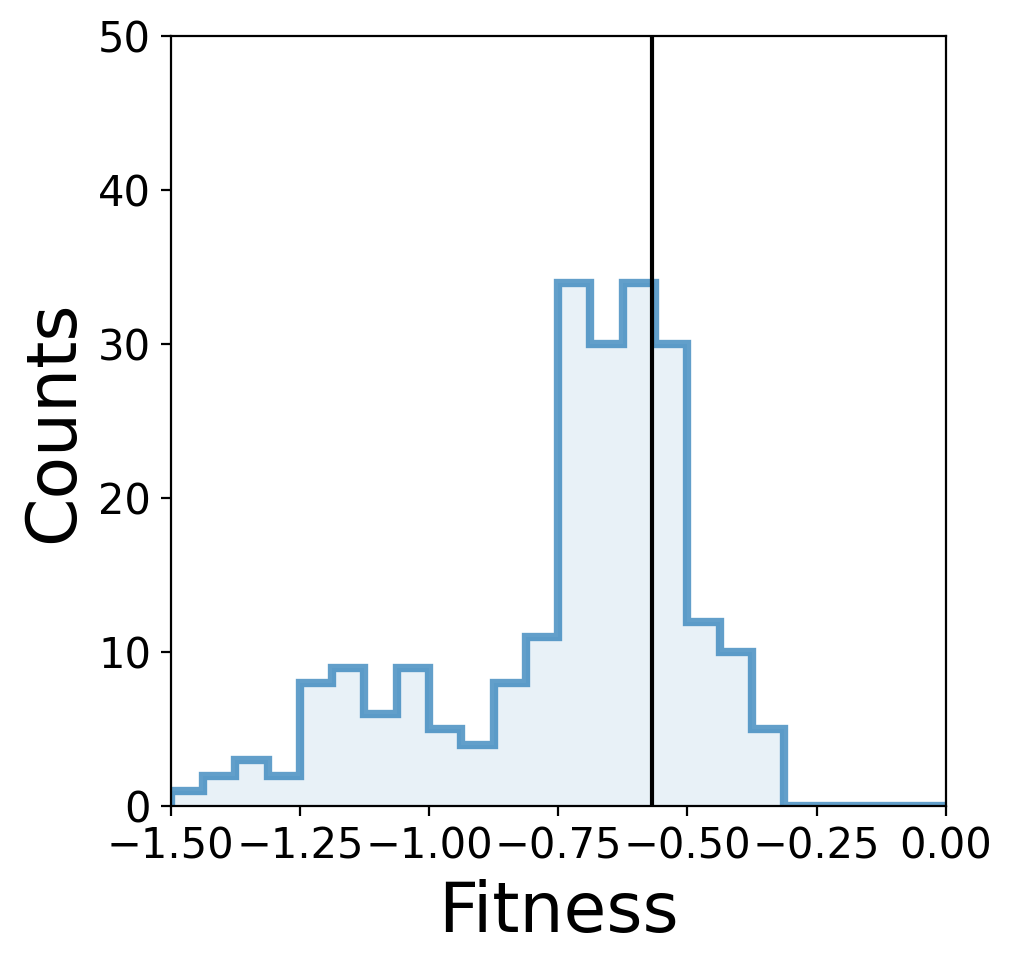

In [291]:
bins = np.linspace(-1.5, 0, 25)
plt.figure(figsize=(5,5))
plt.hist(log['Fitness'], bins=bins, density=False, alpha=0.1, histtype='stepfilled', lw=2, label='All')
plt.hist(log['Fitness'], bins=bins, density=False, alpha=0.7, histtype='step', linewidth=3, label='All', color='tab:blue')
plt.vlines(fitness_threshold, 0, 200, color='k')
plt.xlabel('Fitness', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.ylim((0, 50))
plt.xlim((-1.5, 0))
plt.show()

11 9
[32 49 33 31 54  1 45 13 26 42  9  0 22 35 14 40]
[-0.55033349 -0.53481614 -0.51977508 -0.51640401 -0.51617026 -0.51118107
 -0.50948569 -0.4996593  -0.49632305 -0.48636627 -0.46651358 -0.44482476
 -0.44342774 -0.44171612 -0.4223483  -0.42210802]
[57  5 58 21 44 55 16 52 24 12 25 18 38  7 43]
[-0.54775347 -0.54032974 -0.53926251 -0.53263081 -0.52247533 -0.51764142
 -0.51046599 -0.50044583 -0.49081622 -0.48039142 -0.46768647 -0.46580911
 -0.46343034 -0.40655588 -0.37616763]
Mean: -0.4863408050176601 -0.49079081010735875
Median: -0.4979911738224235 -0.5004458311647682


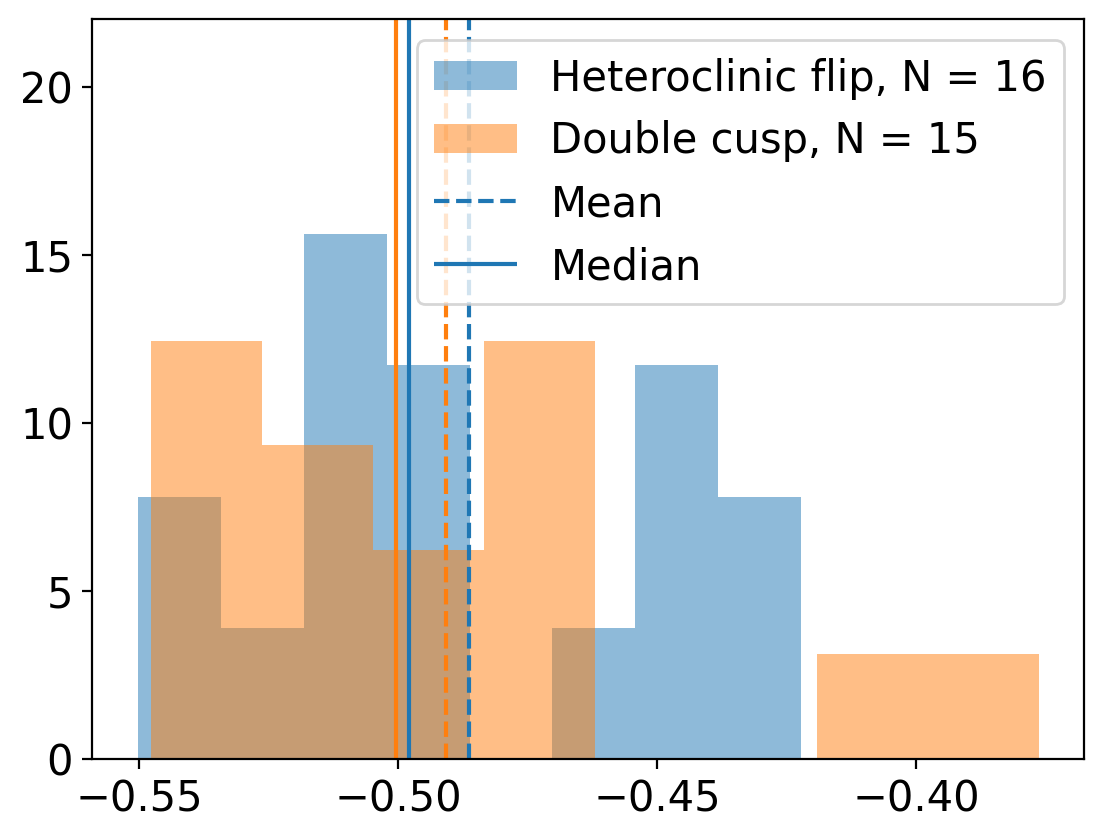

In [44]:
####
ind_flip = np.array([0, 1, 9, 13, 14, 22, 26, 31, 32, 33, 35, 40, 42, 45, 49, 54])
ind_choice = np.array([5, 7, 12, 16, 18, 21, 24, 25, 38, 43, 44, 52, 55, 57, 58])

fit_flip = fitnesses[ind_flip]
fit_choice = fitnesses[ind_choice]

print(np.argmax(fit_flip), np.argmax(fit_choice))   # 40, 43
print(ind_flip[np.argsort(fit_flip)])
print(fit_flip[np.argsort(fit_flip)])

print(ind_choice[np.argsort(fit_choice)])
print(fit_choice[np.argsort(fit_choice)])

print('Mean:', np.mean(fit_flip), np.mean(fit_choice))
print('Median:', np.median(fit_flip), np.median(fit_choice))

plt.hist(fit_flip, bins=8, density=True, alpha=0.5, label='Heteroclinic flip, N = 16')
plt.hist(fit_choice, bins=8, density=True, alpha=0.5, label='Double cusp, N = 15')
plt.vlines(np.mean(fit_flip), 0, 25, color='tab:blue', linestyles='dashed', label='Mean')
plt.vlines(np.mean(fit_choice), 0, 25, color='tab:orange', linestyles='dashed')
plt.vlines(np.median(fit_flip), 0, 25, color='tab:blue', label='Median')
plt.vlines(np.median(fit_choice), 0, 25, color='tab:orange')
plt.legend()
plt.ylim((0, 22))
plt.show()


In [175]:
def insert_sample_slide(pptx_path, image_paths, data_dir, index, timecode):
    # Init presentation
    if not os.path.exists(pptx_path):
        prs = Presentation()
        prs.slide_width = Inches(16)
        prs.slide_height = Inches(9)
    else:
        prs = Presentation(pptx_path)

    slide = prs.slides.add_slide(prs.slide_layouts[6])  # blank

    # Title
    title_box = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(15), Inches(0.5))
    text_frame = title_box.text_frame
    text_frame.text = f"{index:02d} — Timecode: {timecode}"
    p = text_frame.paragraphs[0]
    p.font.size = Pt(24)
    p.font.bold = False
    p.font.name = "Aptos"
    p.alignment = PP_ALIGN.LEFT
    p.font.color.rgb = RGBColor(0, 0, 0)

    # Layout constants
    margin_x = Inches(0.4)
    margin_y = Inches(1.0)
    spacing_x = Inches(0.2)
    spacing_y = Inches(0.1)
    fixed_height = Inches(4.)  # consistent for all images

    # Row 1
    top_y1 = margin_y
    pic0 = slide.shapes.add_picture(image_paths[0], margin_x, top_y1, height=fixed_height)  # traj

    # Row 2
    top_y2 = top_y1 + fixed_height + spacing_y
    pic1 = slide.shapes.add_picture(image_paths[1], margin_x-Inches(0.1), top_y2, height=fixed_height*0.9)  # chir_vs_fgf

    column = max((margin_x + pic0.width + spacing_x), (margin_x + pic1.width + spacing_x))
    pic2 = slide.shapes.add_picture(image_paths[2], column, top_y1, height=fixed_height*0.7)  # valley
    pic3 = slide.shapes.add_picture(image_paths[3], column, top_y2-Inches(0.5), height=fixed_height*1.1)  # pot3d

    for j in range(7):
        filename = data_dir + timecode + '/result_proportions_' + str(j) + '.png'
        slide.shapes.add_picture(filename, Inches(12), margin_y+j*Inches(1.1), height=Inches(1.1))
    prs.save(pptx_path)

/Users/victoria/Code/evoscape/src/evoscape/module_helper_functions.py:125: RuntimeWarning: invalid value encountered in divide
  scale: bool, scale the coordinates to a range of [-1, 1] if True
<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


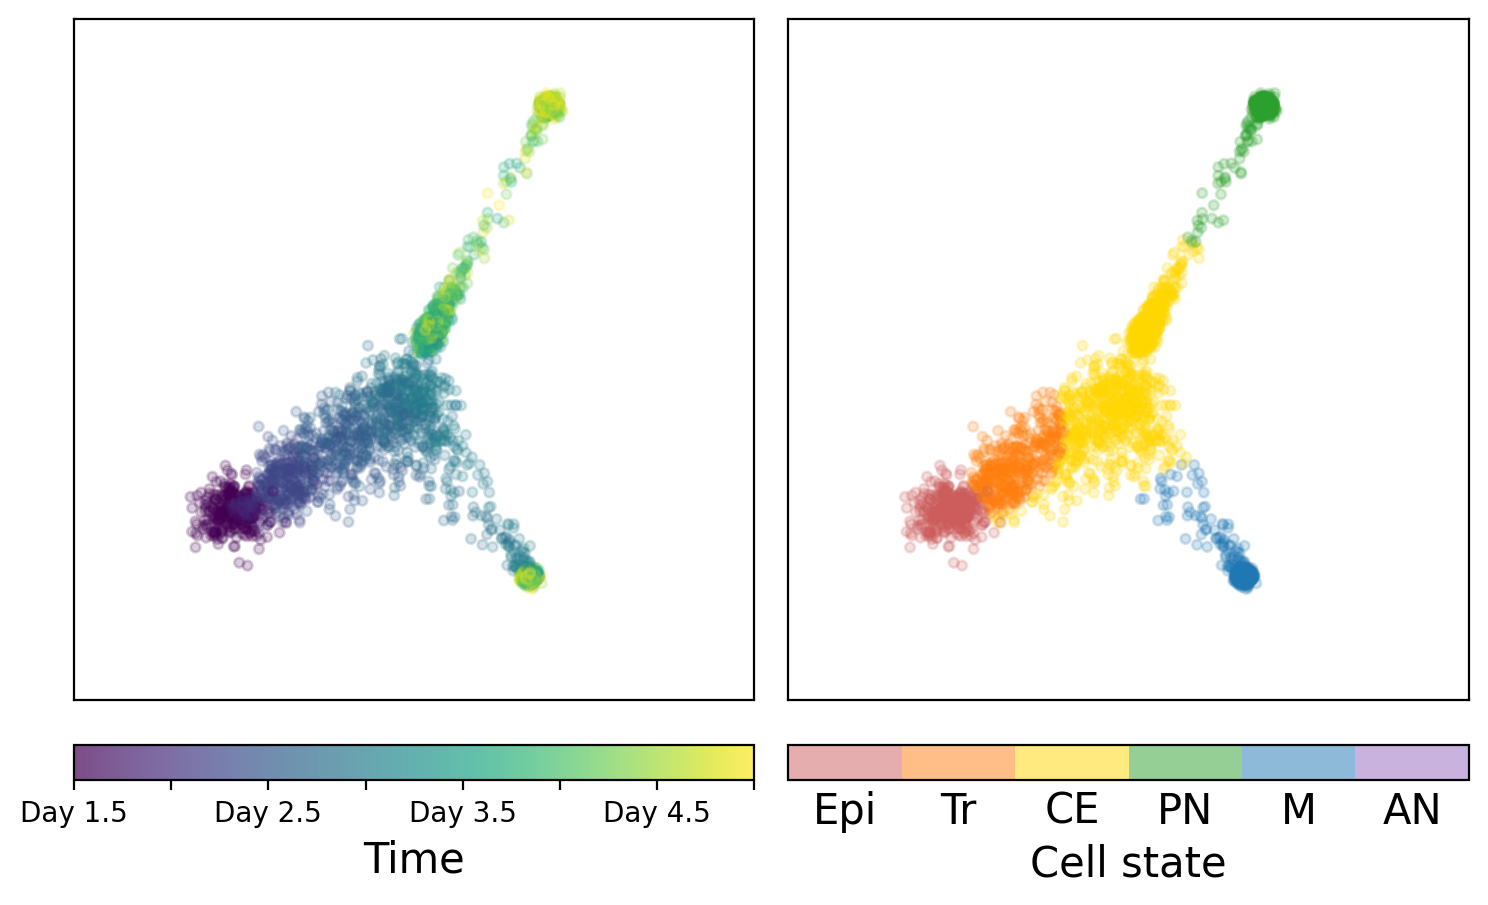

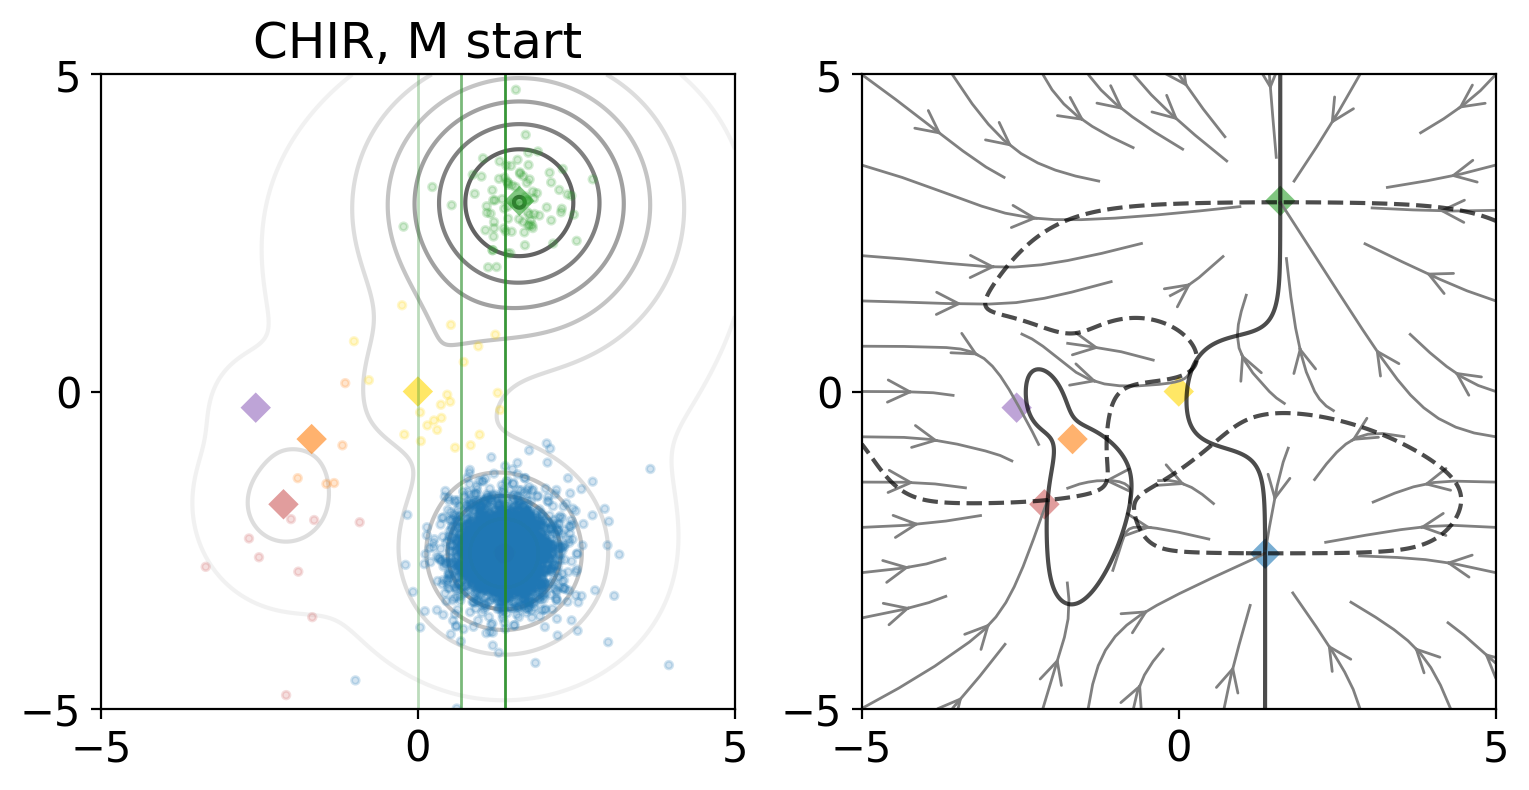

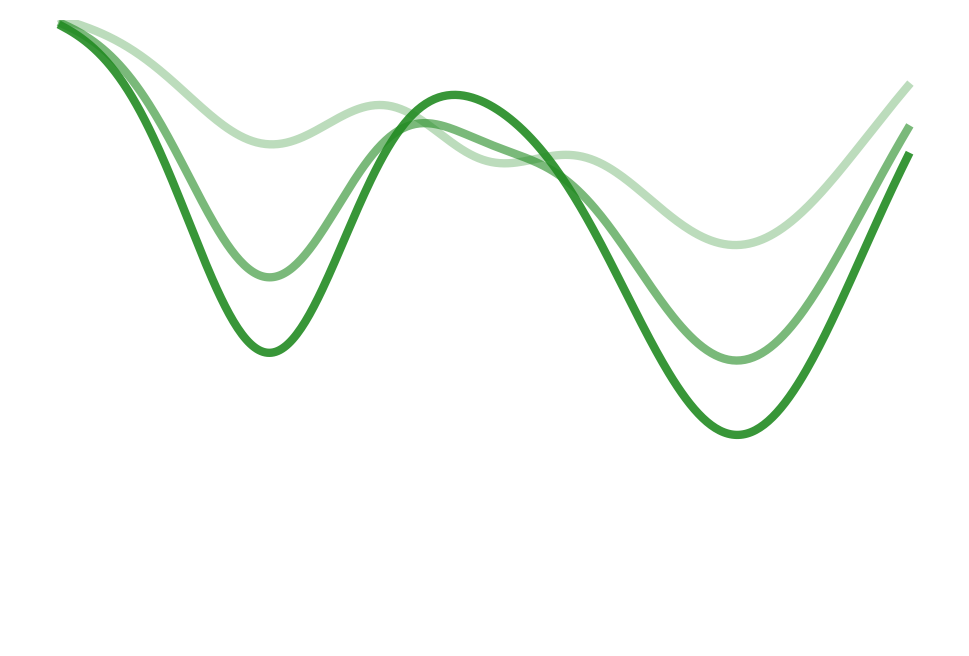

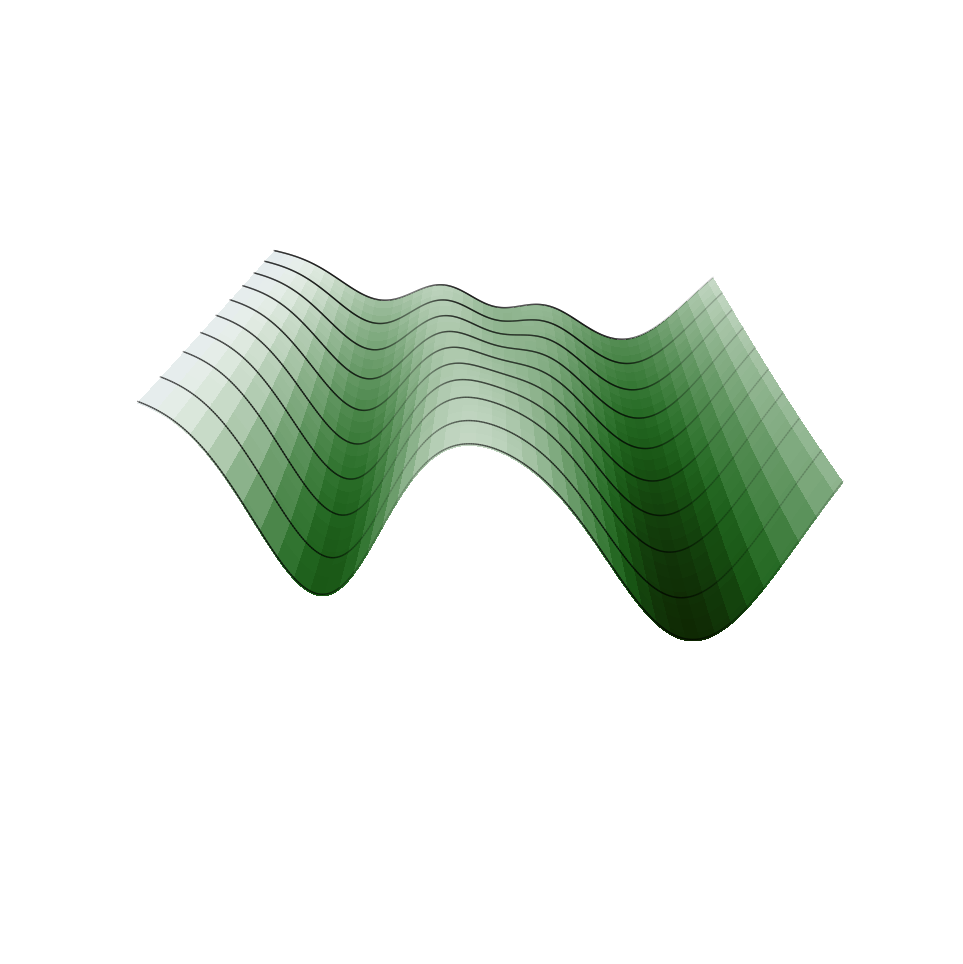

In [288]:
%autoreload

L = 5.
npoints = 401
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)
state_names = ('Epi', 'Tr', 'CE', 'PN', 'M', 'AN')

noise = 0.2
ndt = 50
nt = 15
ncells = 300

init_state = 2

origin = 2
direction = (3,4)
right = None
bottom = 4
left = 0

delta=2.

morphogen_times = (delta*1, delta*3, delta*100, delta*100)   # exp 5
# morphogen_times = (delta*1, delta*3, delta*3, delta*3)   # exp 2
# morphogen_times = (delta*3, delta*3, delta*3, delta*7)    # exp 1


morphogen_times_1 = (delta*0, delta*7., delta*7, delta*100)  # FGF, no Chir
morphogen_times_2 = (-delta*1, -delta*1., delta*7, delta*100)  # Chir
morphogen_times_3 = (-delta*1, delta*7., delta*100, delta*100)   # Chir + FGF
time_pars_exp = (0, delta*7, 15)

n_landscapes = len(timecodes)


# for i in (14, 35, 45, 49):   # flips 
# for i in (16, 18, 21, 22, 42, 58):   # choices
# for i in (58,):
# for ind in (49,):
# for ind in range(60):
for ind in (57,):    ##    5, 49, 58, 14, 18, 40
    timecode = timecodes[ind]
    landscape = landscape_from_timecode(CellDiff_Dataset_Landscape, timecode, data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)

   #   plot trajectories with time colormap
    landscape.morphogen_times = morphogen_times
    time_pars = (0, delta*7, 15)
    landscape.init_cells(300, 0, noise)

    fig0 = vis.get_and_plot_traj(landscape, *time_pars, 4., noise, ndt = ndt, s=12, state_names=state_names,
                                t_ticks = (0, delta*7, 8),
                                t_names=('Day 1.5', '', 'Day 2.5', '', 'Day 3.5', '', 'Day 4.5', ''),)
                                # t_names=('', 'Day 2', '', 'Day 3', '', 'Day 4', '', 'Day 5'),)
    ax = fig0.axes
    # ax[0].set_ylim((-2., 6))
    # ax[1].set_ylim((-2., 6))
    ax[0].set_ylim((-4., 4))
    ax[1].set_ylim((-4., 4))


    time_pars = (0, delta*5, nt)
    fig, ax = plt.subplots(1,2, figsize=(9,5))

    landscape.morphogen_times = morphogen_times_2   # CHIR regime
    landscape.init_cells(ncells, 4, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise*8, ndt=ndt, frozen=False)
    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    # st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)
    st_data = data
    ax[0].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=30, marker='.',  alpha=0.2, edgecolor=None, edgecolors=None)
    ax[0].set_title('CHIR, M start')

    derivs, pot, rot = landscape(delta*0., (xx,yy), return_potentials=True)
    ax[0].contour(xx, yy, pot, zorder=0, cmap='Greys_r', alpha=0.9)

    ax[1].streamplot(xx, yy, derivs[0], derivs[1], density=0.5, arrowsize=2., arrowstyle='->', linewidth=1, color='grey')
    ax[1].contour(xx, yy, derivs[0], (0,), colors=('k',), linestyles='-', linewidths=1.5, alpha=0.7)
    ax[1].contour(xx, yy, derivs[1], (0,), colors=('k',), linestyles='--', linewidths=1.5, alpha=0.7)

# ____________________________________________________________________________

    # fig2 = vis.visualize_potential(landscape, xx[:, 200:305], yy[:, 200:305], t=delta*8., color_scheme='order', rot_contour=False, elev=20, azim=0, cmap_center=0., offset=50.)
    closest_x = min([m.x for m in landscape.module_list[3:5]])
    valley_x = (closest_x/L + 1.)*0.5  # Take locations of M and PN
    valley_x = max((valley_x, 0.6))

    fig1, ax1 = plt.subplots(1,1, figsize=(6,4))
    alphas = np.linspace(0.3, 0.9, 3)
    lines = (npoints*np.linspace(0.5, valley_x, 3)).astype('int')    # 0.5, 0.75, 5 for flip
    for alpha, line in enumerate(lines):
        ax[0].plot((xx[0, line], xx[0, line]), (-L, L), lw=1, c='forestgreen', alpha=alphas[alpha])
        # ax1.plot(yy[:, line], pot[:, line]-pot[n points//2, npoints//2], alpha=alphas[alpha], lw=3, c='forestgreen')
        ax1.plot(yy[:, line], pot[:, line], alpha=alphas[alpha], lw=3, c='forestgreen')


    lines = (npoints*np.linspace(0.5, valley_x, 10)).astype('int')   # 0.5, 0.75, 15 for flip
    max_point = int(npoints*valley_x)+1
    fig2 = vis.visualize_potential(landscape, xx[:, 200:max_point], yy[:, 200:max_point], t=delta*0., color_scheme='order', rot_contour=False, elev=20, azim=0, cmap_center=0., offset=500.)
    ax2 = plt.gca()
    ax2.set_proj_type('persp', focal_length=0.25)
    for line in lines:
        zvals = pot[:, line]
        ydot = derivs[1][:, line]
        normed = (ydot - ydot.min()) / (ydot.max() - ydot.min())
        for i in range(len(zvals) - 1):
            x = [xx[i, line], xx[i+1, line]]
            y = [yy[i, line], yy[i+1, line]]
            z = [zvals[i] + 0.1, zvals[i+1] + 0.1]
            alpha = 0.1 + 0.6 * (normed[i])  # control opacity
            lw = 0.5
            ax2.plot(x, y, z, color='k', alpha=alpha, linewidth=lw, zorder=10)

    ax2.set_zlim((np.min(pot[:, line])*2., 5.))
    ax1.set_ylim((np.min(pot[:, line])*1.5, np.max(pot[:, line])*2))

    ax2.set_xlim((0,(valley_x-0.5)*L*2.))
    ax2.axis('off')
    ax1.set_xlabel(r'Phenotypic coordinate $y$')
    ax1.set_ylabel('Potential')
    ax1.axis('off')
    ax1.set_xticks((-L, 0, L))
    ax1.set_yticks((0,), labels=('CE',))

    for axi in ax:
        axi.set_ylim((-L,L))
        axi.set_xlim((-L,L))
        axi.set_yticks((-L, 0, L))
        axi.set_xticks((-L, 0, L))
        axi.set_aspect('equal')
        for im, module in enumerate(landscape.module_list):
            axi.scatter(module.x, module.y, c=colors[im], marker='D', s=60, edgecolor='None', alpha=0.6)

    fig0.savefig(f'../panels/traj_{ind:02d}.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'../panels/escape_{ind:02d}.png', dpi=200, bbox_inches='tight')
    fig1.savefig(f'../panels/sections_{ind:02d}.png', dpi=200, bbox_inches='tight')
    fig2.savefig(f'../panels/potential_{ind:02d}.png', dpi=200, bbox_inches='tight')

    plt.show()
    for figure in (fig0, fig, fig1, fig2):

        plt.close(figure)

    panels_dir = '../panels/'
    image_paths = [panels_dir+f"traj_{ind:02d}.png", panels_dir+f"escape_{ind:02d}.png",
               panels_dir+f"sections_{ind:02d}.png", panels_dir+f"potential_{ind:02d}.png"]

    # insert_sample_slide(panels_dir+"Landscapes_10.pptx", image_paths, data_dir, index=ind, timecode=str(timecode))


## Experiment 2

In [434]:
#   Exp 2
%autoreload

L = 5.
npoints = 401
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)
state_names = ('Epi', 'Tr', 'CE', 'PN', 'M', 'AN')

noise = 0.2
ndt = 50
nt = 15
ncells = 300

init_state = 2

origin = 2
direction = (3,4)
right = 3
bottom = 4
left = None

delta=2.


morphogen_times = (delta*1, delta*3, delta*3, delta*3)   # exp 2
morphogen_times_2 = (-delta*1, -delta*1., -delta*1, -delta*1)  # end. FGF
time_pars_exp = (0, delta*7, 15)

n_landscapes = len(timecodes)

for ind in range(60):
# for ind in (57,):    ##    5, 49, 58, 14, 18, 40
    timecode = timecodes[ind]
    landscape = landscape_from_timecode(CellDiff_Dataset_Landscape, timecode, data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)

   #   plot trajectories with time colormap
    landscape.morphogen_times = morphogen_times
    time_pars = (0, delta*7, 15)
    landscape.init_cells(300, 0, noise)

    fig0 = vis.get_and_plot_traj(landscape, *time_pars, 4., noise, ndt = ndt, s=12, state_names=state_names,
                                t_ticks = (0, delta*7, 8),
                                t_names=('Day 1.5', '', 'Day 2.5', '', 'Day 3.5', '', 'Day 4.5', ''),)
                                # t_names=('', 'Day 2', '', 'Day 3', '', 'Day 4', '', 'Day 5'),)
    ax = fig0.axes
    ax[0].set_ylim((-4., 4))
    ax[1].set_ylim((-4., 4))


    time_pars = (0, delta*5, nt)
    fig, ax = plt.subplots(1,2, figsize=(9,5))
    landscape.morphogen_times = morphogen_times_2   # end FGF regime
    landscape.init_cells(ncells, 4, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise*6, ndt=ndt, frozen=False)
    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    # st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)
    st_data = data
    ax[0].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=30, marker='.',  alpha=0.2, edgecolor=None, edgecolors=None)
    ax[0].set_title('End. FGF, M start')

    derivs, pot, rot = landscape(delta*0., (xx,yy), return_potentials=True)
    ax[0].contour(xx, yy, pot, zorder=0, cmap='Greys_r', alpha=0.9)

    ax[1].streamplot(xx, yy, derivs[0], derivs[1], density=0.5, arrowsize=2., arrowstyle='->', linewidth=1, color='grey')
    ax[1].contour(xx, yy, derivs[0], (0,), colors=('k',), linestyles='-', linewidths=1.5, alpha=0.7)
    ax[1].contour(xx, yy, derivs[1], (0,), colors=('k',), linestyles='--', linewidths=1.5, alpha=0.7)

# ____________________________________________________________________________

    # fig2 = vis.visualize_potential(landscape, xx[:, 200:305], yy[:, 200:305], t=delta*8., color_scheme='order', rot_contour=False, elev=20, azim=0, cmap_center=0., offset=50.)
    closest_x = min([m.x for m in landscape.module_list[3:5]])
    valley_x = (closest_x/L + 1.)*0.5  # Take locations of M and PN
    valley_x = max((valley_x, 0.6))

    fig1, ax1 = plt.subplots(1,1, figsize=(6,4))
    alphas = np.linspace(0.3, 0.9, 3)
    lines = (npoints*np.linspace(0.5, valley_x, 3)).astype('int')    # 0.5, 0.75, 5 for flip
    for alpha, line in enumerate(lines):
        ax[0].plot((xx[0, line], xx[0, line]), (-L, L), lw=1, c='forestgreen', alpha=alphas[alpha])
        # ax1.plot(yy[:, line], pot[:, line]-pot[n points//2, npoints//2], alpha=alphas[alpha], lw=3, c='forestgreen')
        ax1.plot(yy[:, line], pot[:, line], alpha=alphas[alpha], lw=3, c='forestgreen')


    lines = (npoints*np.linspace(0.5, valley_x, 10)).astype('int')   # 0.5, 0.75, 15 for flip
    max_point = int(npoints*valley_x)+1
    fig2 = vis.visualize_potential(landscape, xx[:, 200:max_point], yy[:, 200:max_point], t=delta*0., color_scheme='order', rot_contour=False, elev=20, azim=0, cmap_center=0., offset=500.)
    ax2 = plt.gca()
    ax2.set_proj_type('persp', focal_length=0.25)
    for line in lines:
        zvals = pot[:, line]
        ydot = derivs[1][:, line]
        normed = (ydot - ydot.min()) / (ydot.max() - ydot.min())
        for i in range(len(zvals) - 1):
            x = [xx[i, line], xx[i+1, line]]
            y = [yy[i, line], yy[i+1, line]]
            z = [zvals[i] + 0.1, zvals[i+1] + 0.1]
            alpha = 0.1 + 0.6 * (normed[i])  # control opacity
            lw = 0.5
            ax2.plot(x, y, z, color='k', alpha=alpha, linewidth=lw, zorder=10)

    ax2.set_zlim((np.min(pot[:, line])*2., 5.))
    ax1.set_ylim((np.min(pot[:, line])*1.5, np.max(pot[:, line])*2))

    ax2.set_xlim((0,(valley_x-0.5)*L*2.))
    ax2.axis('off')
    ax1.set_xlabel(r'Phenotypic coordinate $y$')
    ax1.set_ylabel('Potential')
    ax1.axis('off')
    ax1.set_xticks((-L, 0, L))
    ax1.set_yticks((0,), labels=('CE',))

    for axi in ax:
        axi.set_ylim((-L,L))
        axi.set_xlim((-L,L))
        axi.set_yticks((-L, 0, L))
        axi.set_xticks((-L, 0, L))
        axi.set_aspect('equal')
        for im, module in enumerate(landscape.module_list):
            axi.scatter(module.x, module.y, c=colors[im], marker='D', s=60, edgecolor='None', alpha=0.6)

    fig0.savefig(f'../panels/traj_{ind:02d}_2.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'../panels/escape_{ind:02d}_2.png', dpi=200, bbox_inches='tight')
    fig1.savefig(f'../panels/sections_{ind:02d}_2.png', dpi=200, bbox_inches='tight')
    fig2.savefig(f'../panels/potential_{ind:02d}_2.png', dpi=200, bbox_inches='tight')

    # plt.show()
    for figure in (fig0, fig, fig1, fig2):

        plt.close(figure)

    panels_dir = '../panels/'
    image_paths = [panels_dir+f"traj_{ind:02d}_2.png", panels_dir+f"escape_{ind:02d}_2.png",
               panels_dir+f"sections_{ind:02d}_2.png", panels_dir+f"potential_{ind:02d}_2.png"]

    insert_sample_slide(panels_dir+"Landscapes_10_exp2.pptx", image_paths, data_dir, index=ind, timecode=str(timecode))


/Users/victoria/Code/evoscape/src/evoscape/module_helper_functions.py:125: RuntimeWarning: invalid value encountered in divide
  scale: bool, scale the coordinates to a range of [-1, 1] if True
<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
/Users/victoria/Code/evoscape/src/evoscape/module_helper_functions.py:125: RuntimeWarning: invalid value encountered in divide
  scale: bool, scale the coordinates to a range of [-1, 1] if True
<string>

## Supplementary figure for Epi-AN-CE decision


/Users/victoria/Code/evoscape/src/evoscape/module_helper_functions.py:125: RuntimeWarning: invalid value encountered in divide
  scale: bool, scale the coordinates to a range of [-1, 1] if True
<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


Exp 1


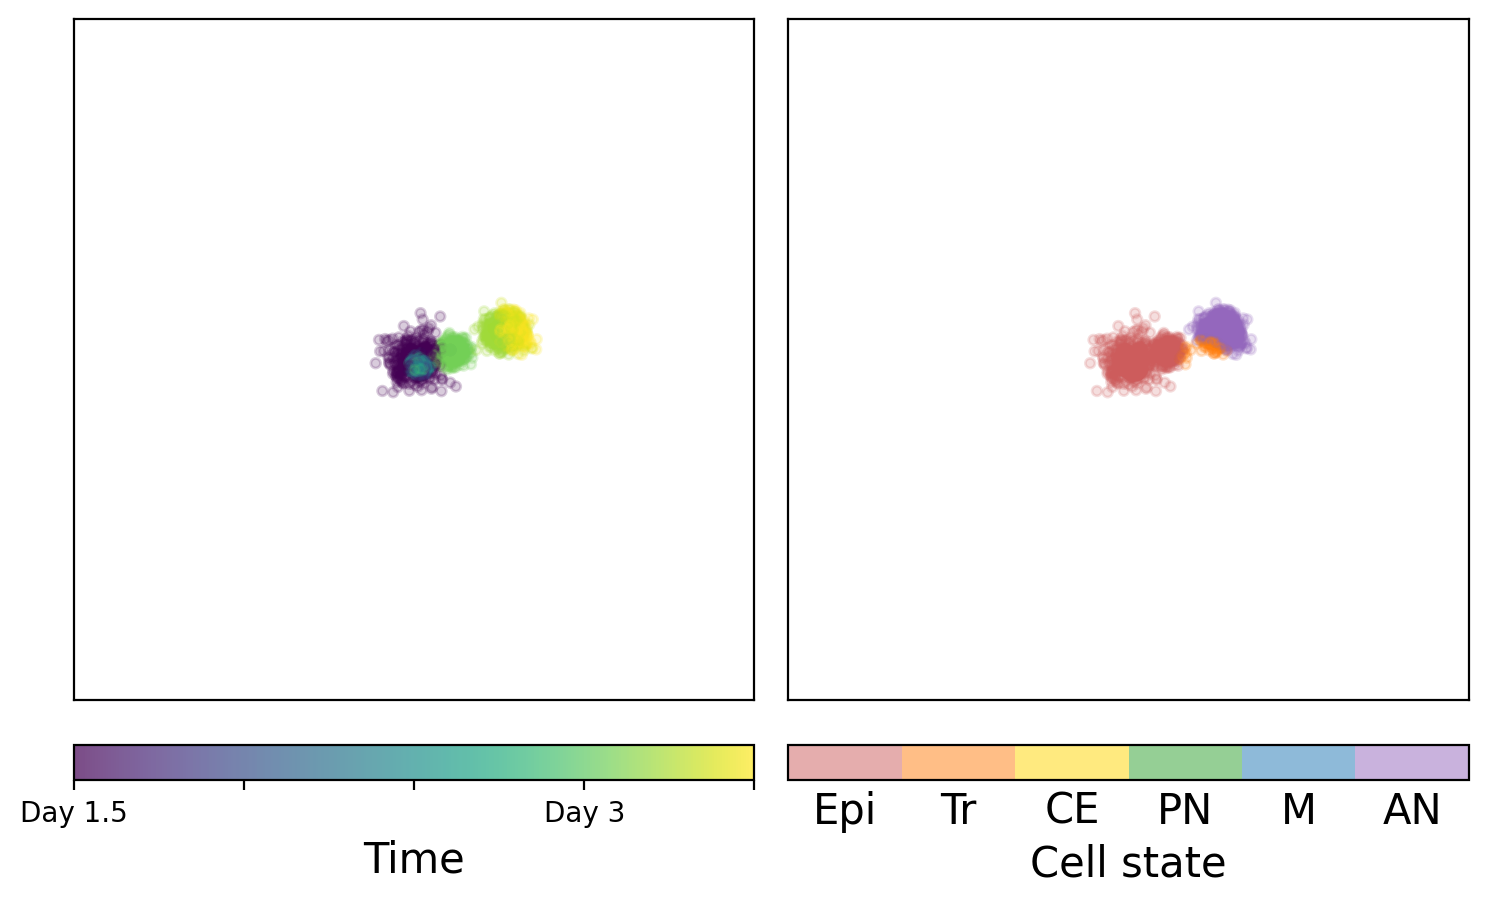

Exp 2-7


<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


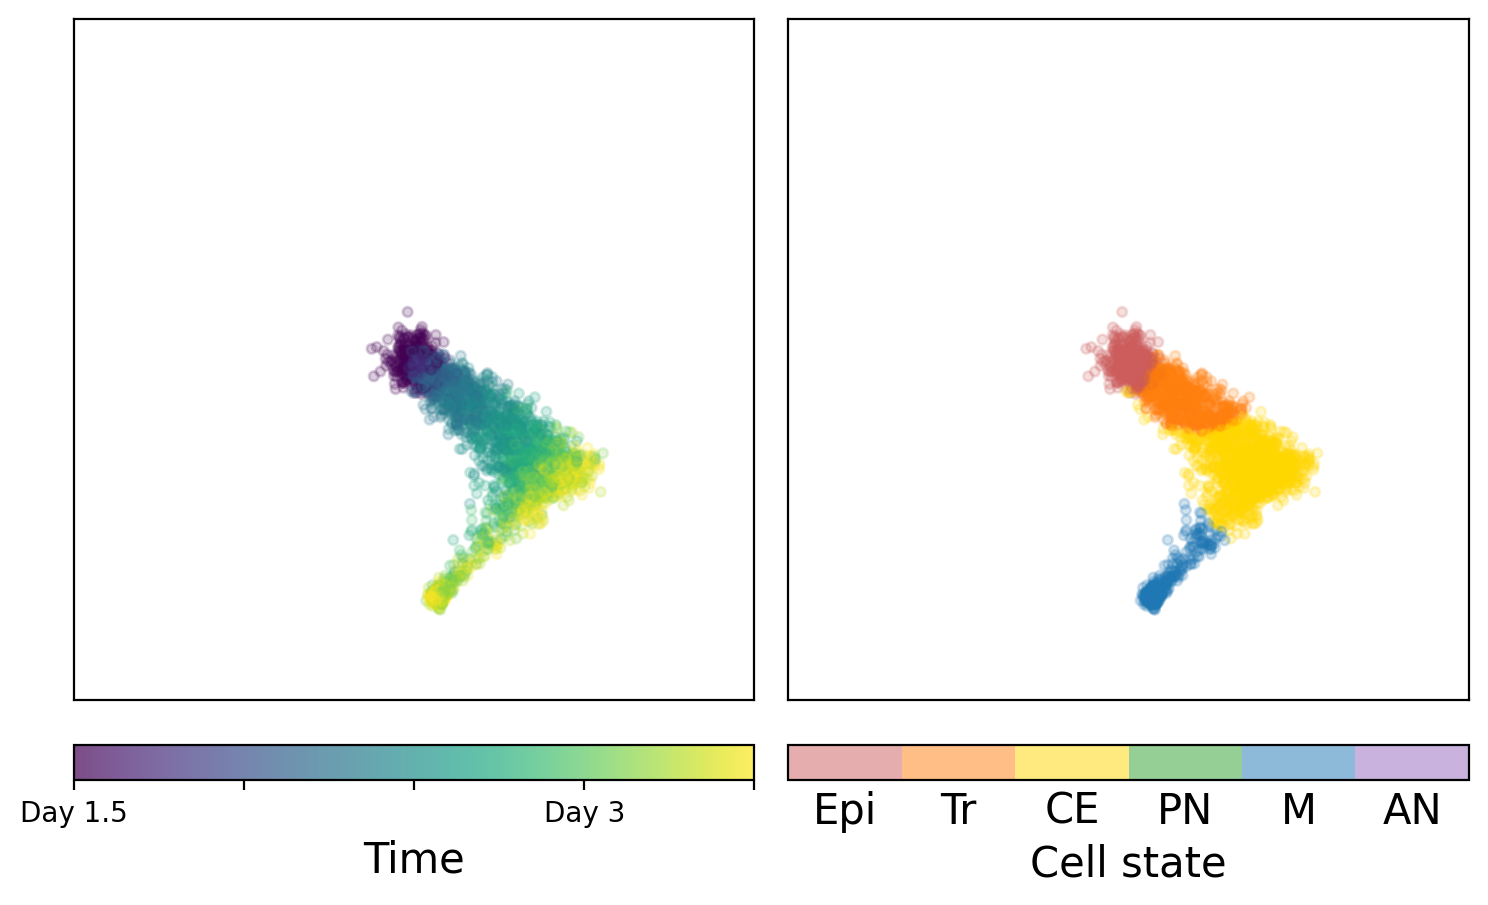

End. FGF


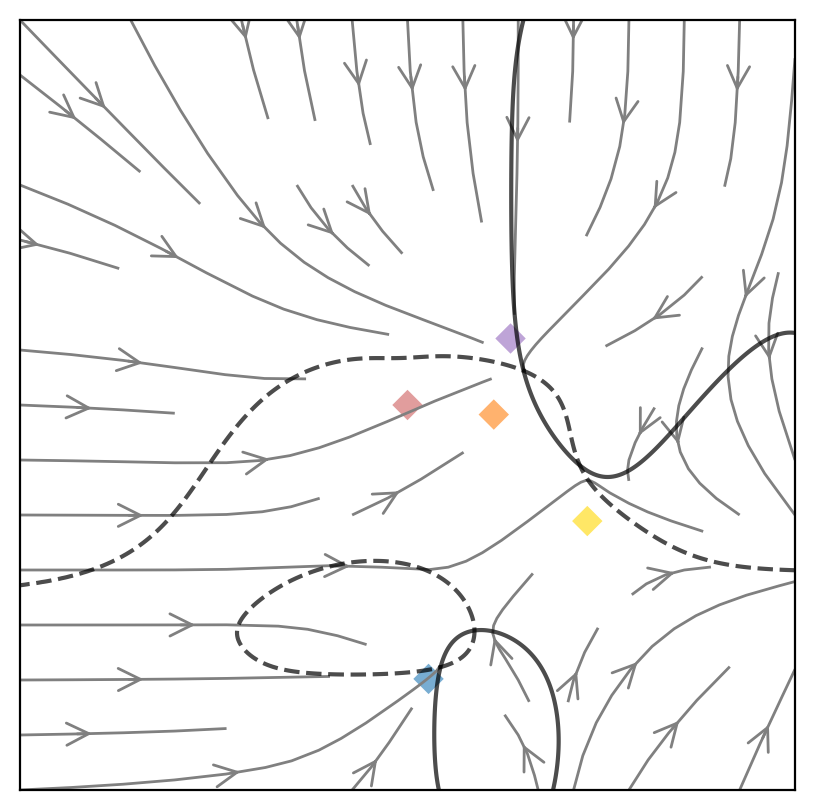

CHIR+FGF


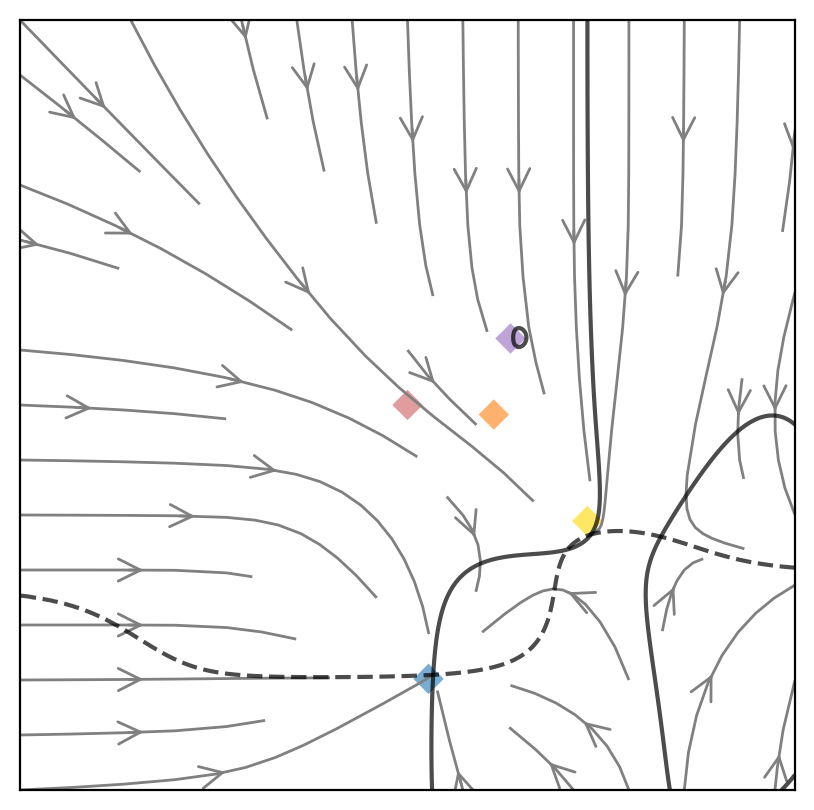

In [428]:
L = 5.
npoints = 401
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)
state_names = ('Epi', 'Tr', 'CE', 'PN', 'M', 'AN')

noise = 0.2
ndt = 50
nt = 15
ncells = 300

init_state = 0

origin = 0
direction = (2,5)
right = 2
bottom = 2
left = None

delta=2.


morphogen_times_1 = (delta*3, delta*3, delta*3, delta*3)    # exp 1 (FGF -> end. FGF)
morphogen_times_2 = (delta*1, delta*100, delta*100, delta*100)   # FGF -> FGF + CHIR (start of exp 2-7)
morphogen_times_3 = (delta*1, delta*3, delta*3, delta*3)   # exp 2

n_landscapes = len(timecodes)

for ind in (57,):    #    18,8
    timecode = timecodes[ind]
    landscape = landscape_from_timecode(CellDiff_Dataset_Landscape, timecode, data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
# ________ Exp 1 _______________________________
    print('Exp 1')
    landscape.morphogen_times = morphogen_times_1
    time_pars = (0, delta*4, 15)
    landscape.init_cells(300, 0, noise)
    fig0 = vis.get_and_plot_traj(landscape, *time_pars, L, noise, ndt = ndt, s=12, state_names=state_names,
                                t_ticks = (0, delta*4, 5),
                                t_names=('Day 1.5', '', '', 'Day 3', ''),)
    # ax = fig0.axes
    # ax[0].set_ylim((-2., 6))
    # ax[1].set_ylim((-2., 6))
    plt.show()

# ________ Exp 2-7 beginning ____________________
    print('Exp 2-7')
    landscape.morphogen_times = morphogen_times_2
    time_pars = (0, delta*4, 11)
    landscape.init_cells(300, 0, noise)

    fig0 = vis.get_and_plot_traj(landscape, *time_pars, L, noise, ndt = ndt, s=12, state_names=state_names,
                                t_ticks = (0, delta*4, 5),
                                t_names=('Day 1.5', '', '', 'Day 3', ''),)
    plt.show()

# ______ Streamplots ____________________________
    print('End. FGF')
    landscape.morphogen_times = morphogen_times_3
    fig, ax = vis.visualize_landscape_t(landscape, xx, yy, delta*4., color_scheme='order', circles=False)
    for im, module in enumerate(landscape.module_list):
            ax.scatter(module.x, module.y, c=colors[im], marker='D', s=60, edgecolor='None', alpha=0.6)
    plt.show()

    print('CHIR+FGF')
    fig, ax = vis.visualize_landscape_t(landscape, xx, yy, delta*2., color_scheme='order', circles=False)
    for im, module in enumerate(landscape.module_list):
            ax.scatter(module.x, module.y, c=colors[im], marker='D', s=60, edgecolor='None', alpha=0.6)
    plt.show()




## Supplementary figure for rare transitions

/Users/victoria/Code/evoscape/src/evoscape/module_helper_functions.py:125: RuntimeWarning: invalid value encountered in divide
  scale: bool, scale the coordinates to a range of [-1, 1] if True
<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


Exp 2
0.7833333333333333


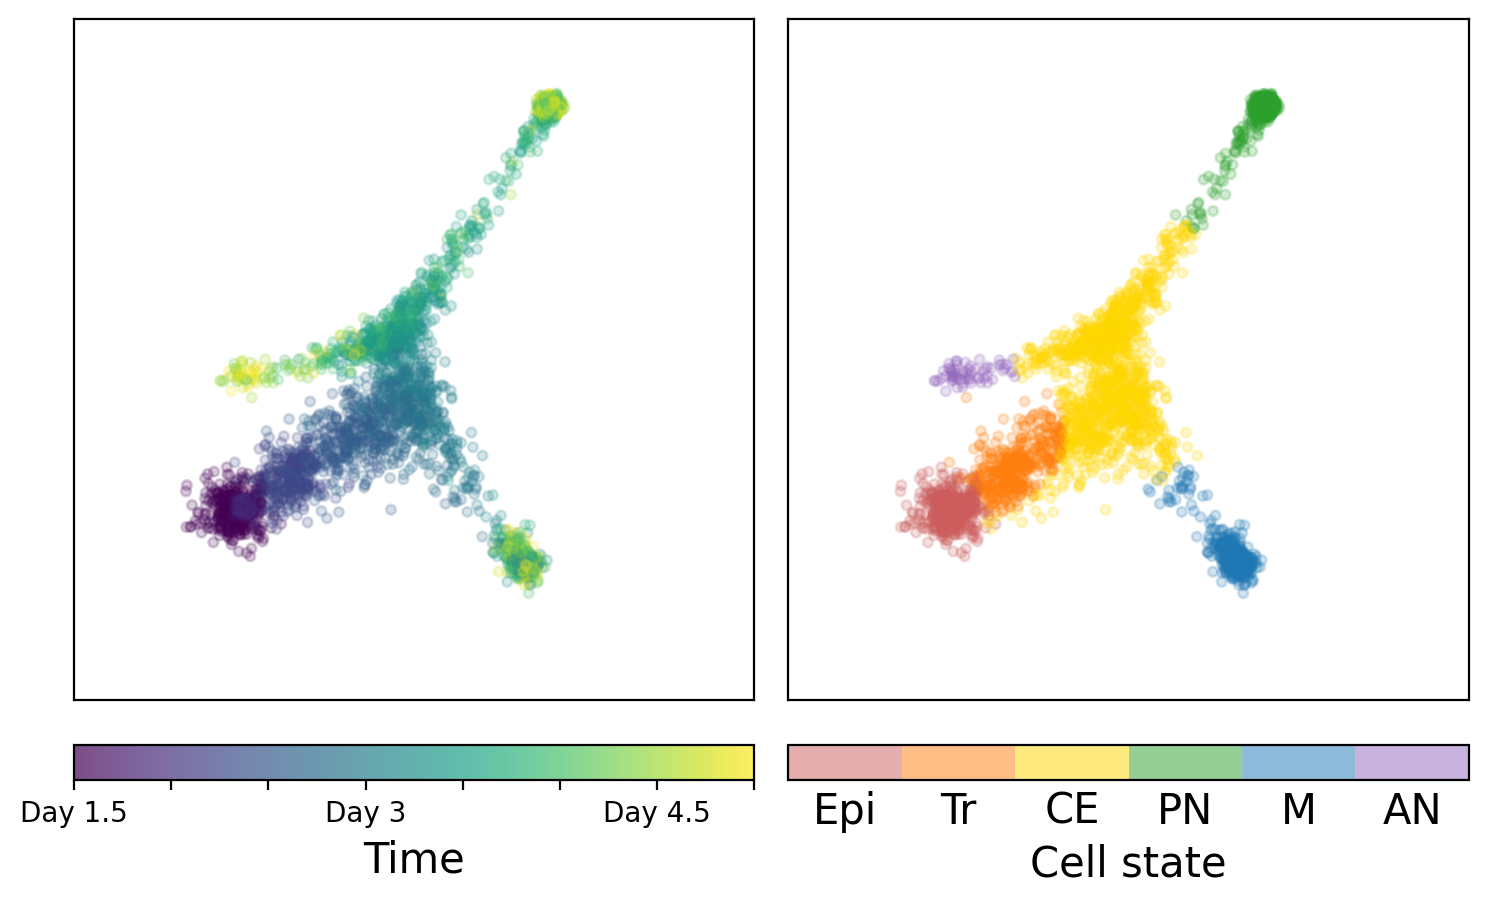

Exp 5


<string>:24: RuntimeWarning: divide by zero encountered in divide
<string>:24: RuntimeWarning: invalid value encountered in divide
/Users/victoria/Code/evoscape/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


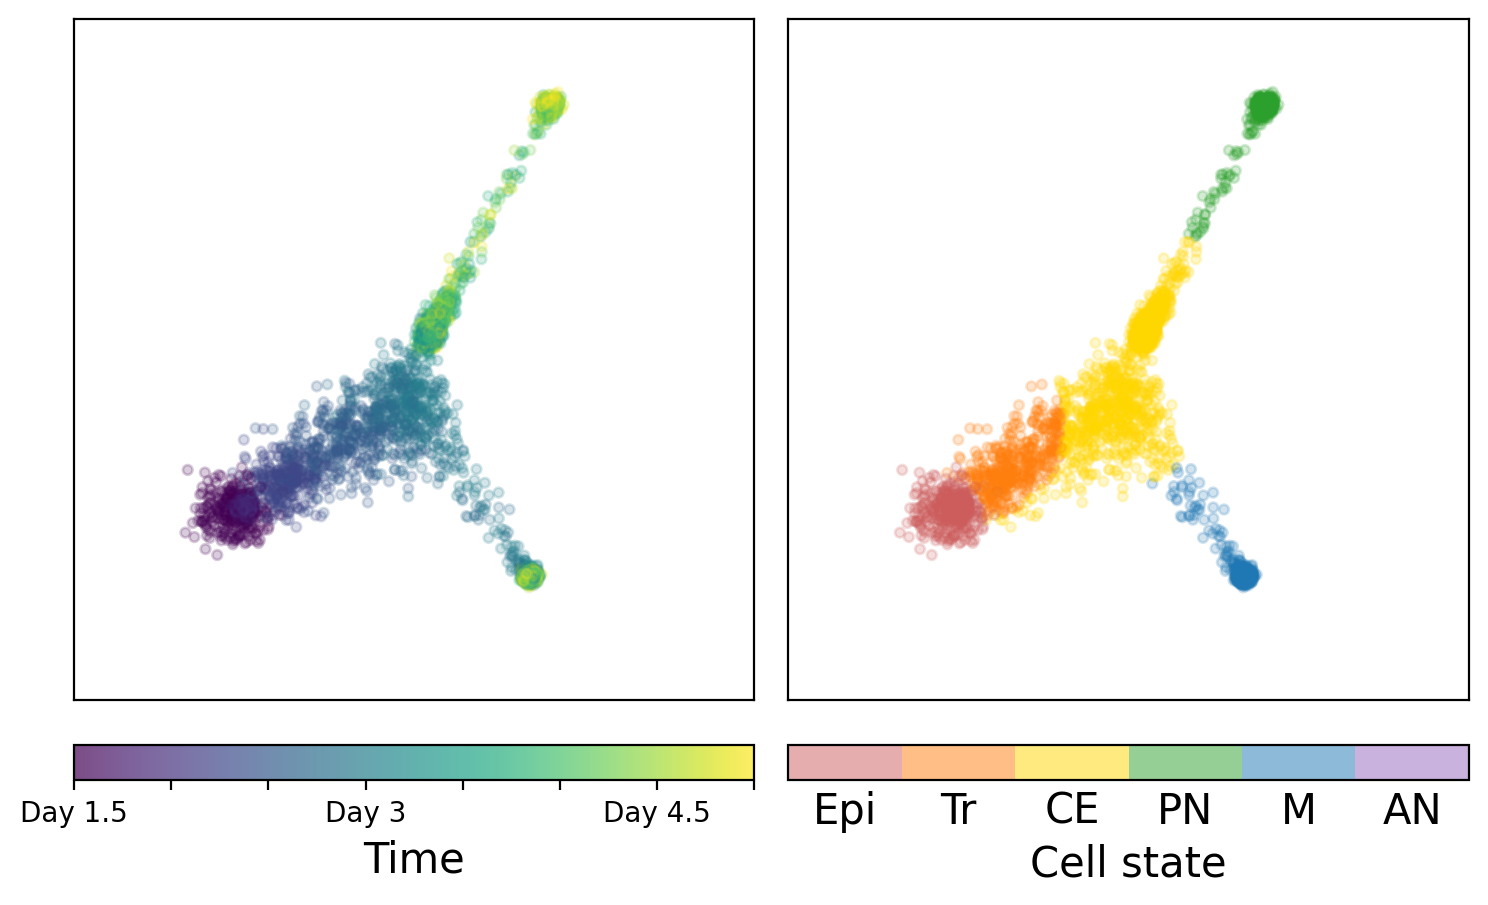

In [427]:
morphogen_times_5 = (delta*1, delta*3, delta*100, delta*100)   # exp 5
morphogen_times_2 = (delta*1, delta*3, delta*3, delta*3)   # exp 2


L = 4.
npoints = 401
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)
state_names = ('Epi', 'Tr', 'CE', 'PN', 'M', 'AN')

noise = 0.2
ndt = 50
nt = 15
ncells = 300

init_state = 0

origin = 2
direction = (3,4)
right = None
bottom = 4
left = 0

delta=2.

n_landscapes = len(timecodes)

for ind in (57,):    #    18,  59, 30, 8
    timecode = timecodes[ind]
    landscape = landscape_from_timecode(CellDiff_Dataset_Landscape, timecode, data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)

    print('Exp 2')
    landscape.morphogen_times = morphogen_times_2
    time_pars = (0, delta*7, 15)
    landscape.init_cells(ncells, 0, noise)
    fig0 = vis.get_and_plot_traj(landscape, *time_pars, L, noise, ndt = ndt, s=12, state_names=state_names,
                                t_ticks = (0, delta*7, 8),
                                t_names=('Day 1.5', '', '', 'Day 3', '', '', 'Day 4.5', ''),)
    print(np.sum(landscape.cell_states==3)/300)
    # ax = fig0.axes
    # ax[0].set_ylim((-3., 5))
    # ax[1].set_ylim((-3., 5))
    plt.show()

    print('Exp 5')
    landscape.morphogen_times = morphogen_times_5
    time_pars = (0, delta*7, 15)
    landscape.init_cells(ncells, 0, noise)

    fig0 = vis.get_and_plot_traj(landscape, *time_pars, L, noise, ndt = ndt, s=12, state_names=state_names,
                                t_ticks = (0, delta*7, 8),
                                t_names=('Day 1.5', '', '', 'Day 3', '', '', 'Day 4.5', ''),)
    # ax = fig0.axes
    # ax[0].set_ylim((-3., 5))
    # ax[1].set_ylim((-3., 5))
    plt.show()


#### Visualizations

/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_31187/289758969.py:11: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T


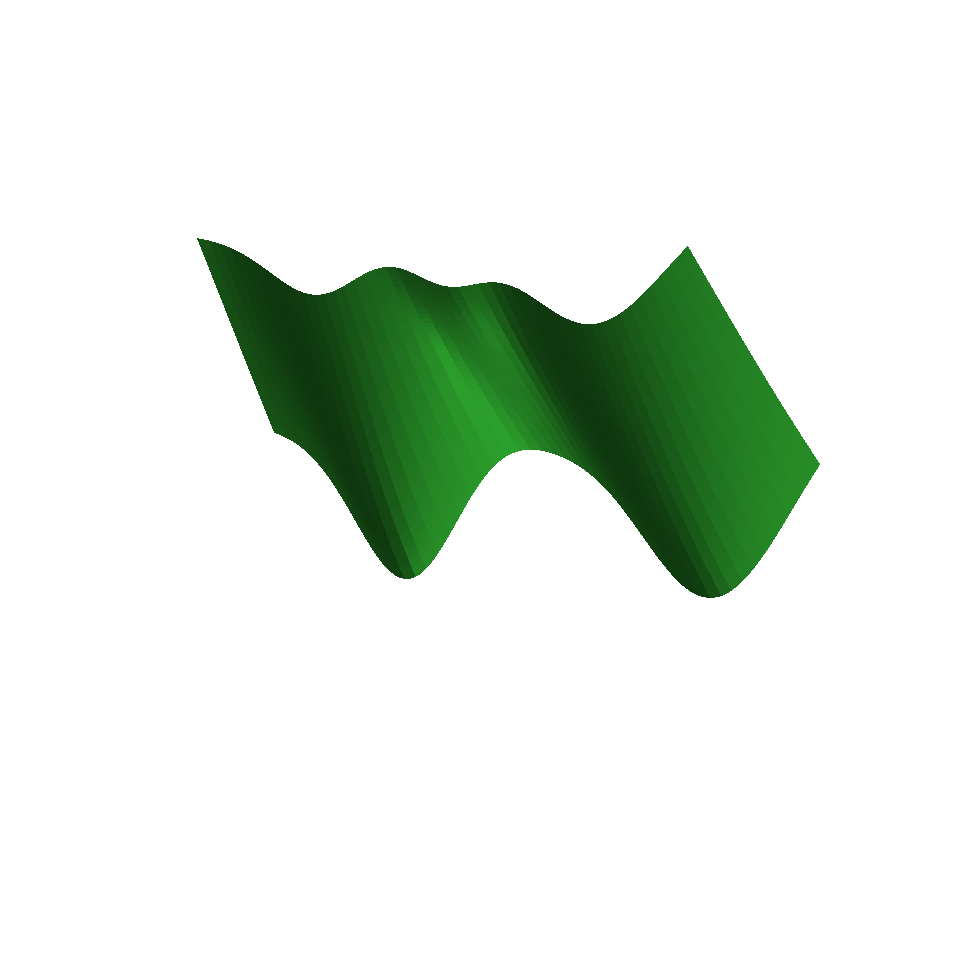

In [95]:
L = 5.
npoints = 1001
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

for ind in (58,):  # 49, 16,
    timecode = timecodes[ind]
    landscape = landscape_from_timecode(timecode, data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
    landscape.morphogen_times = morphogen_times_2   # CHIR regime

    closest_x = min([m.x for m in landscape.module_list[3:5]])
    valley_x = (closest_x/L + 1.)*0.5  # Take locations of M and PN
    valley_x = max((valley_x, 0.6))
    max_point = int(npoints*valley_x)+1
    start_point = int(npoints*0.5)

    derivs, pot, rot = landscape(delta*0., (xx,yy), return_potentials=True)
    fig, ax2 = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(6, 6))
    ax2.plot_surface(xx[:, start_point:max_point], yy[:, start_point:max_point], pot[:, start_point:max_point], color='tab:green', linewidth=0, antialiased=False)
    # fig2 = vis.visualize_potential(landscape, xx[:, 200:max_point], yy[:, 200:max_point], t=delta*0., color_scheme='order', rot_contour=False, elev=20, azim=0, cmap_center=0., offset=500.)
    ax2.view_init(elev=20, azim=-10)
    ax2.set_zlim((np.min(pot[:, max_point])*2., 5.))
    ax2.set_xlim((0,(valley_x-0.5)*L*2.))
    ax2.axis('off')

    np.save(f'../3D_potential_{ind:02d}.npy', pot[:, start_point:max_point])
    plt.show()

/Users/victoria/Code/evoscape/src/evoscape/module_helper_functions.py:125: RuntimeWarning: invalid value encountered in divide
  scale: bool, scale the coordinates to a range of [-1, 1] if True


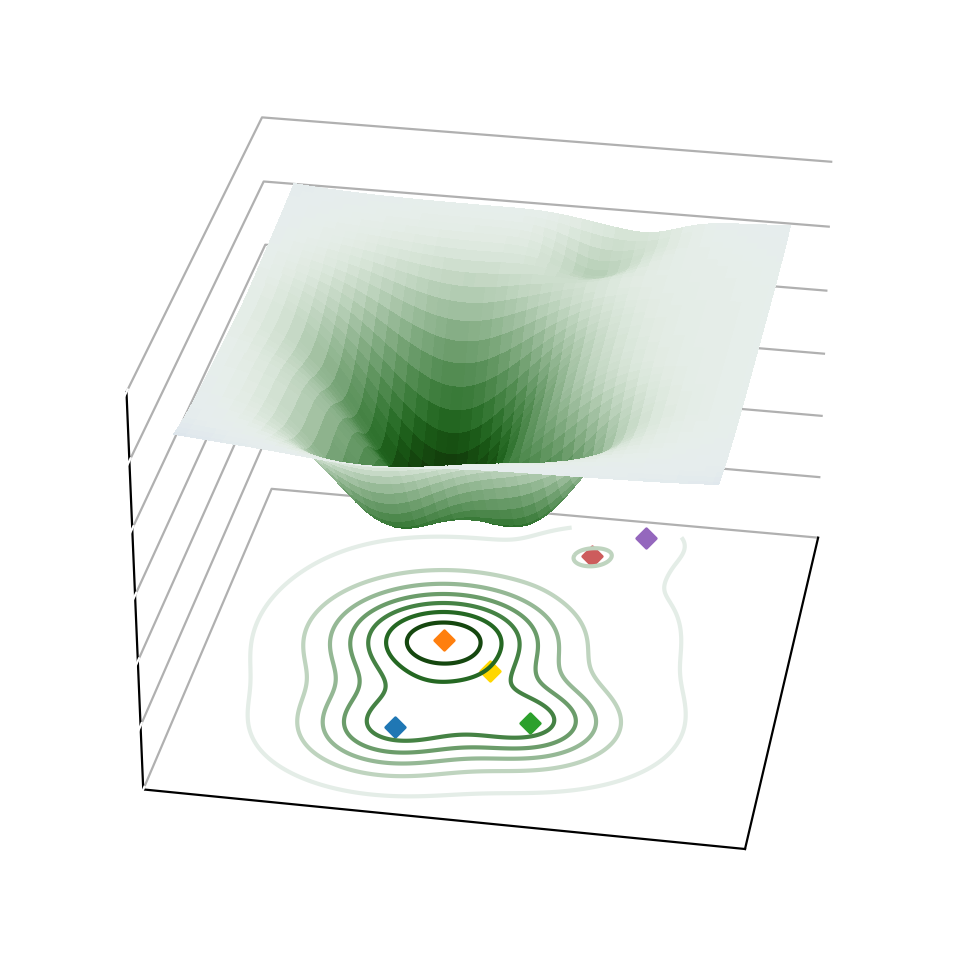

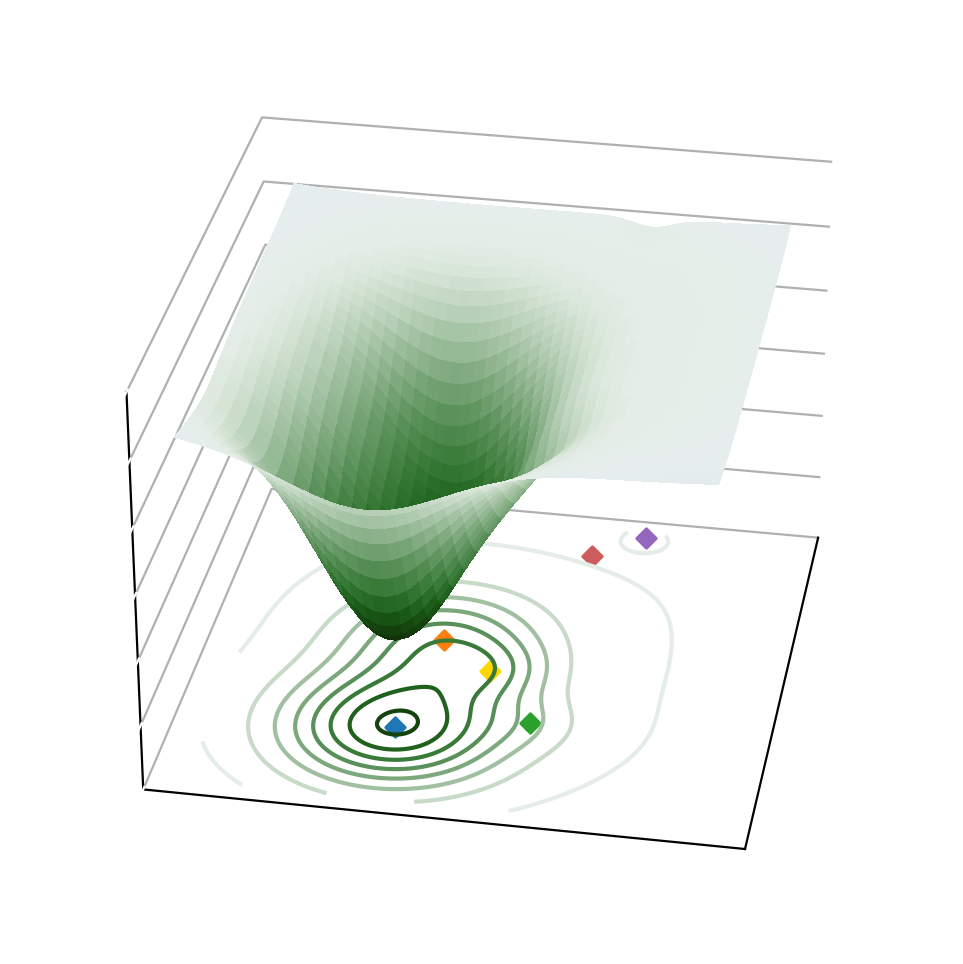

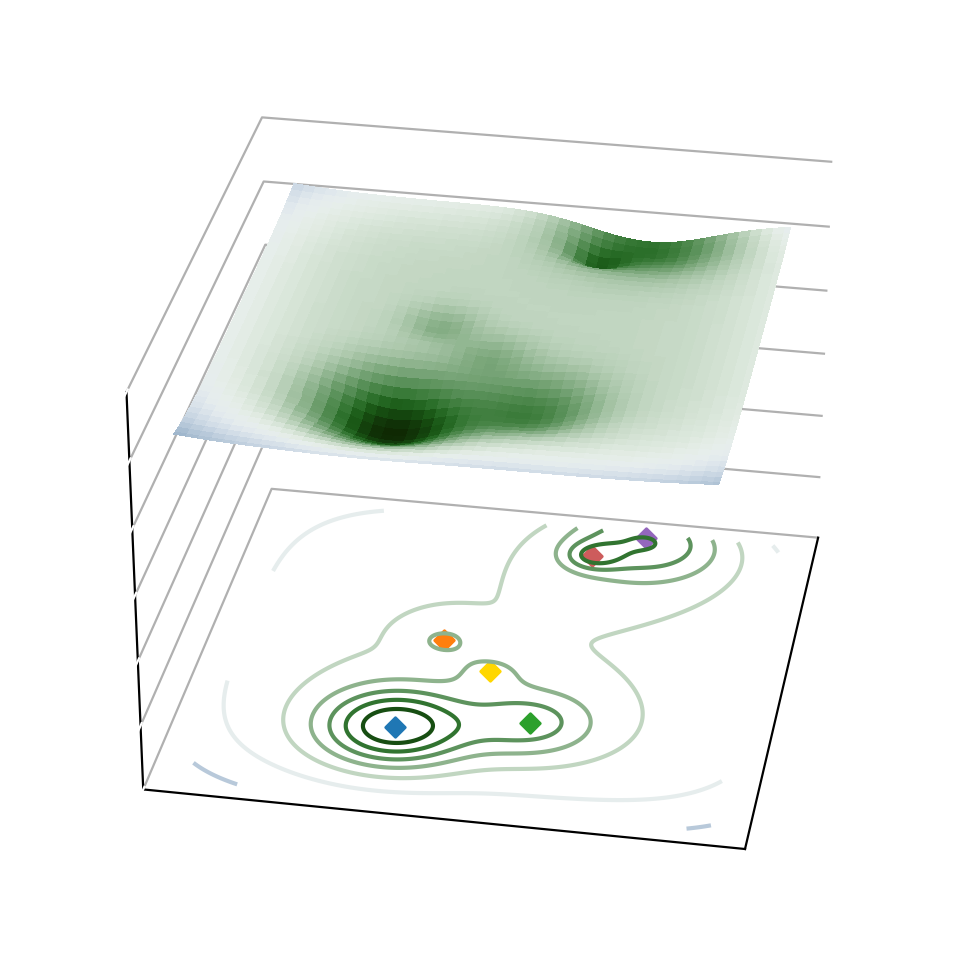

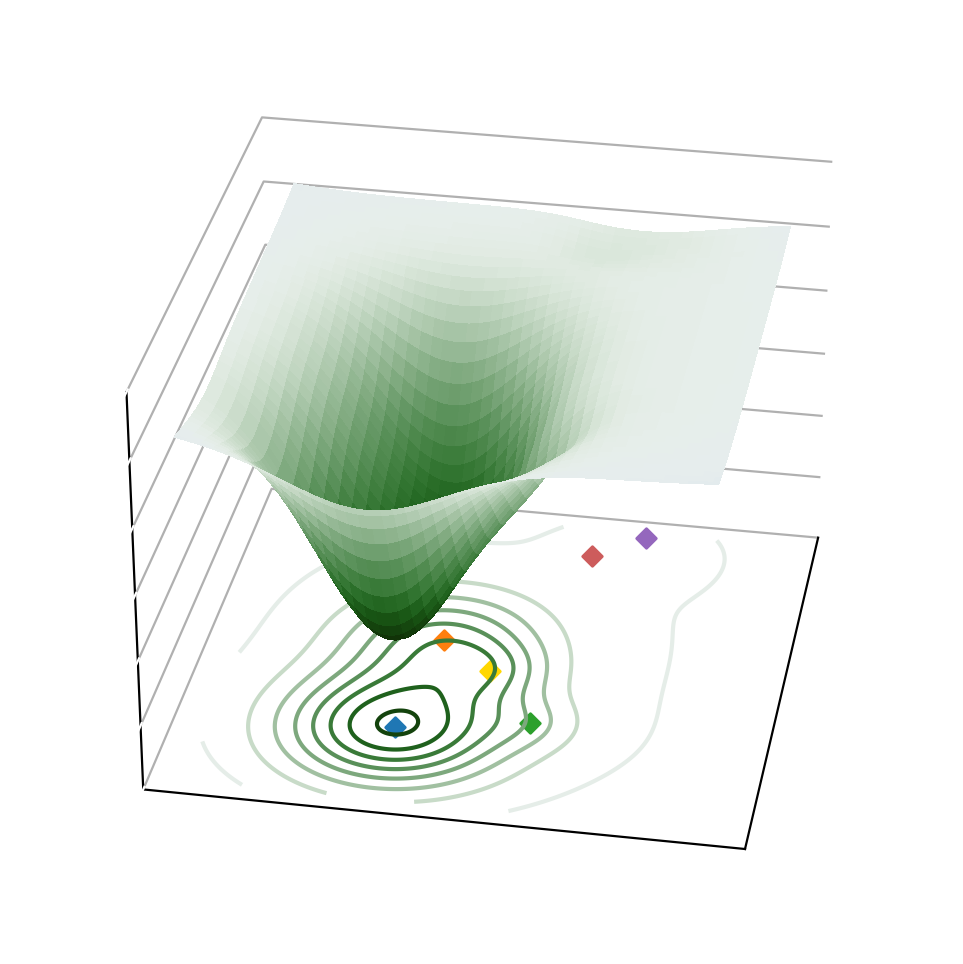

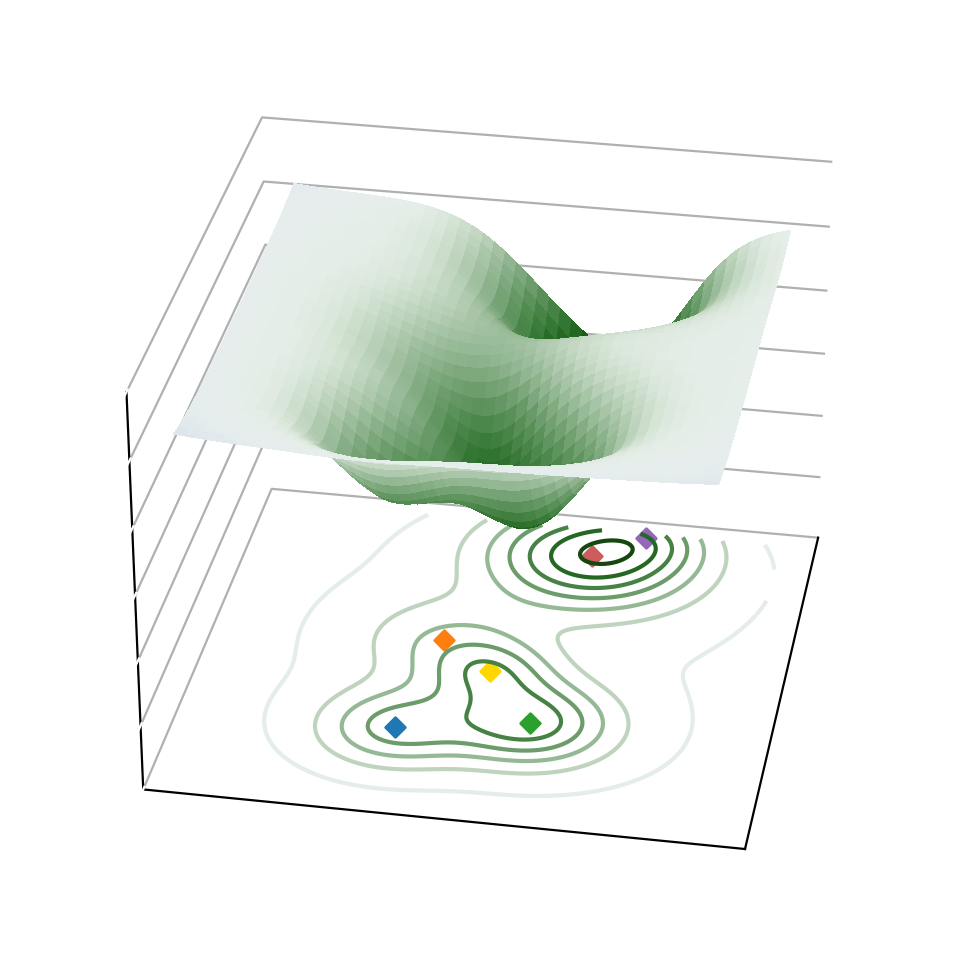

In [222]:
landscape_pars = {'A0': 0.005, 'regime': mr_piecewise}

L = 5.
npoints = 401
qx = np.linspace(-6, 5, npoints)
qy = np.linspace(-5, 5, npoints)
xx, yy = np.meshgrid(qx,qy, indexing = 'xy')
L = 5.5

for ind in (38,):  # 49, 16,
    timecode = timecodes[ind]
    landscape = landscape_from_timecode(CellDiff_Dataset_Landscape, timecode, data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=2, direction=(3,4), left=0, right=None, bottom=4)
    for regime in range(5):
        fig = vis.visualize_potential(landscape, xx, yy, regime=regime, t=None, color_scheme='order', rot_contour=False, elev=30, azim=10, cmap_center=1., offset=None, scatter=True, zlim=(-50, 10))
        ax = fig.get_axes()
        ax[0].set_xlim((-6.5,5.5))
        # ax[0].set_ylim((-L,L))

## ________________________________________________________________

48


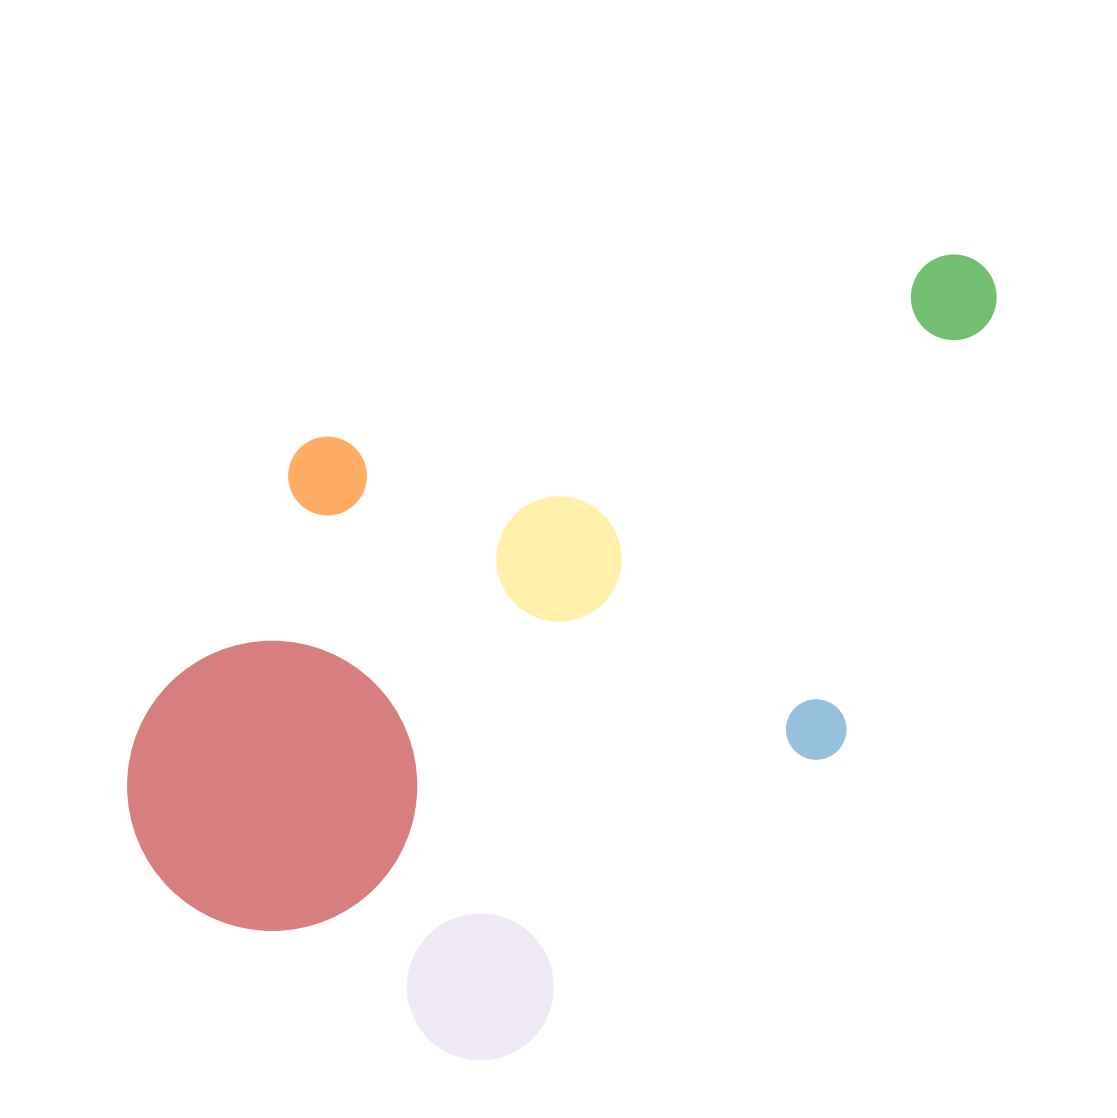

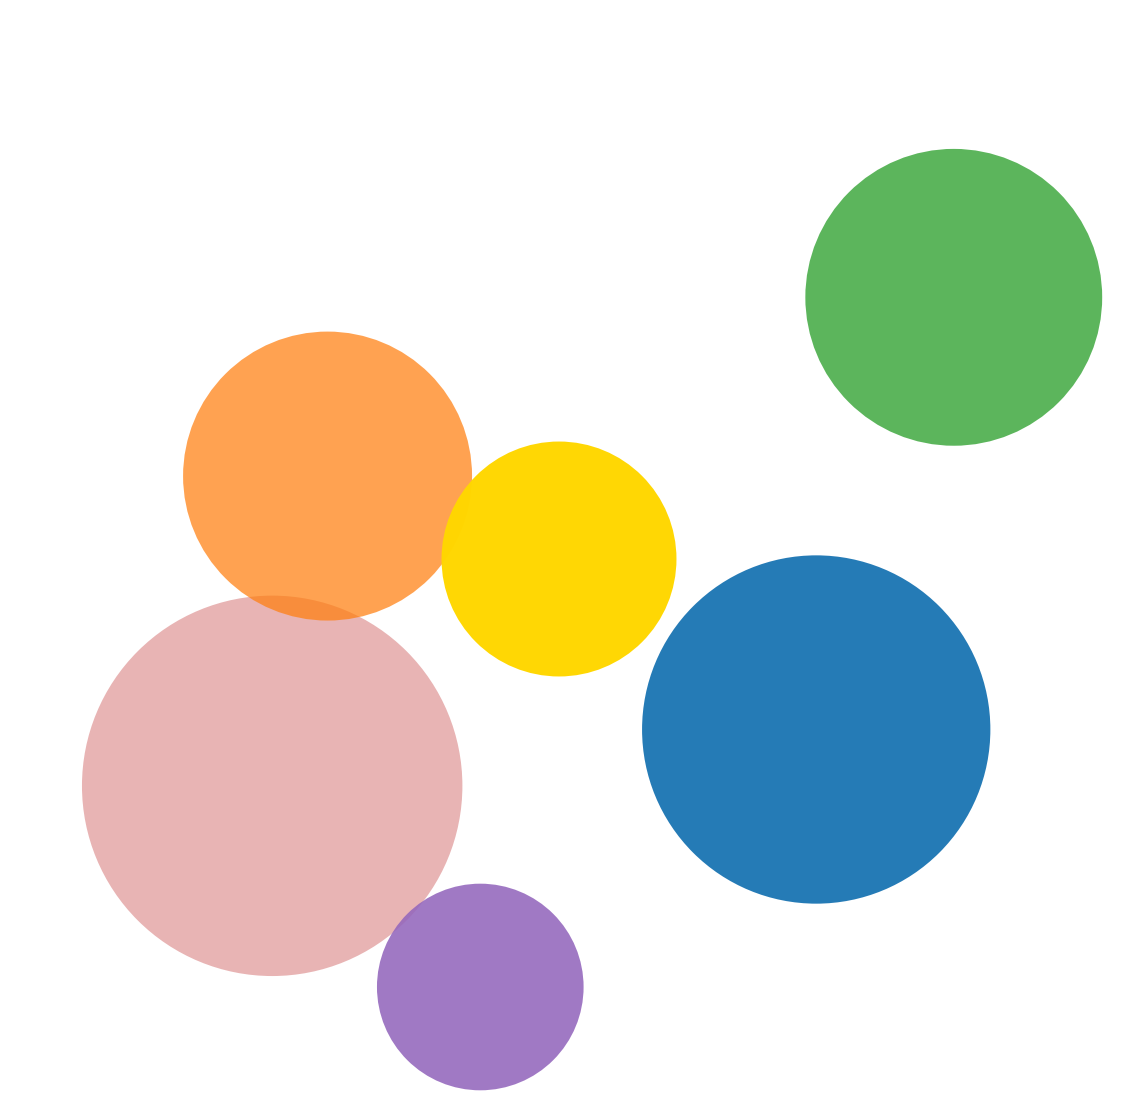

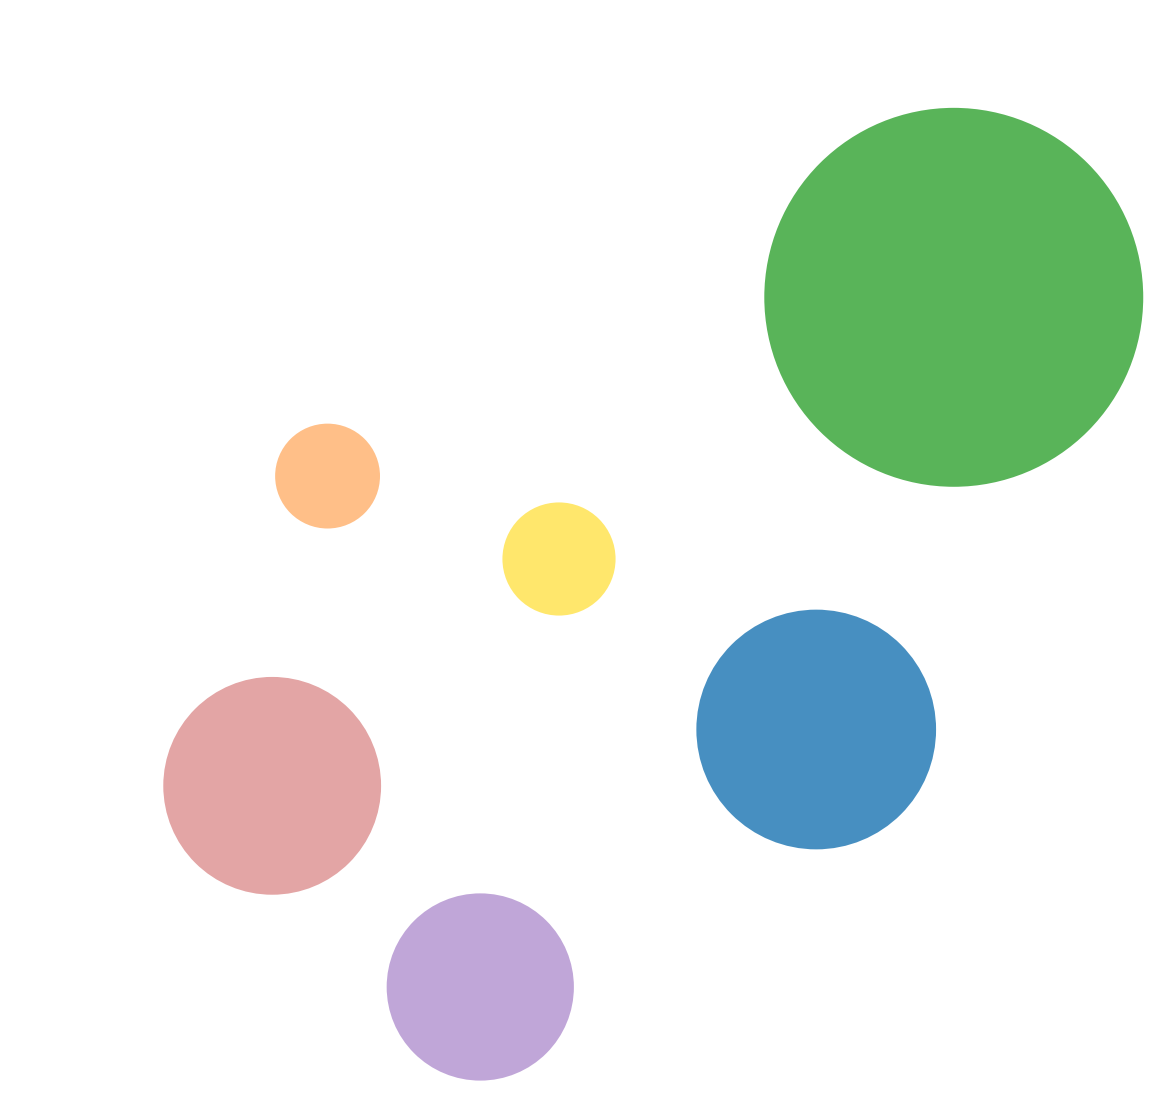

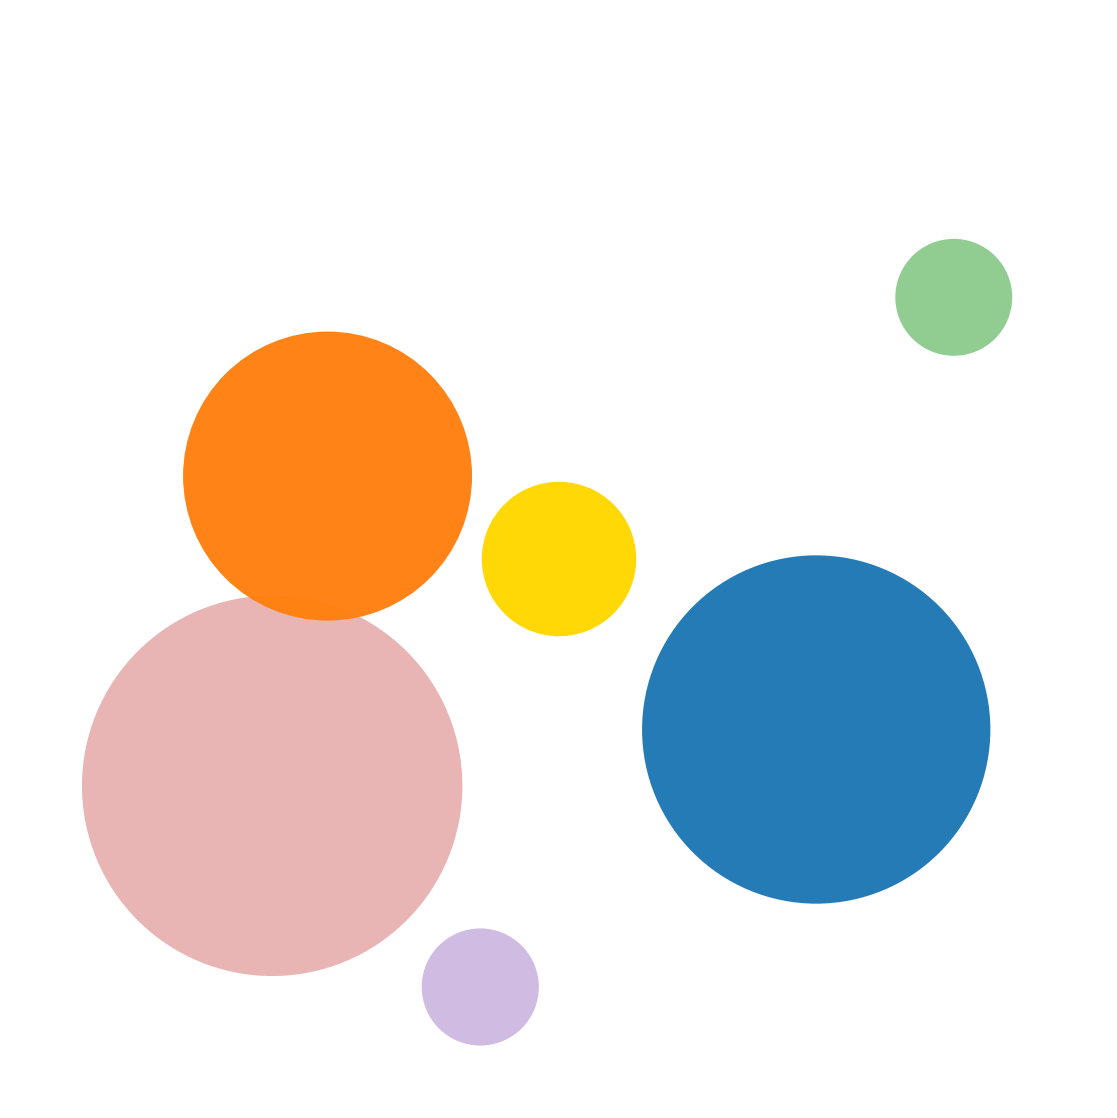

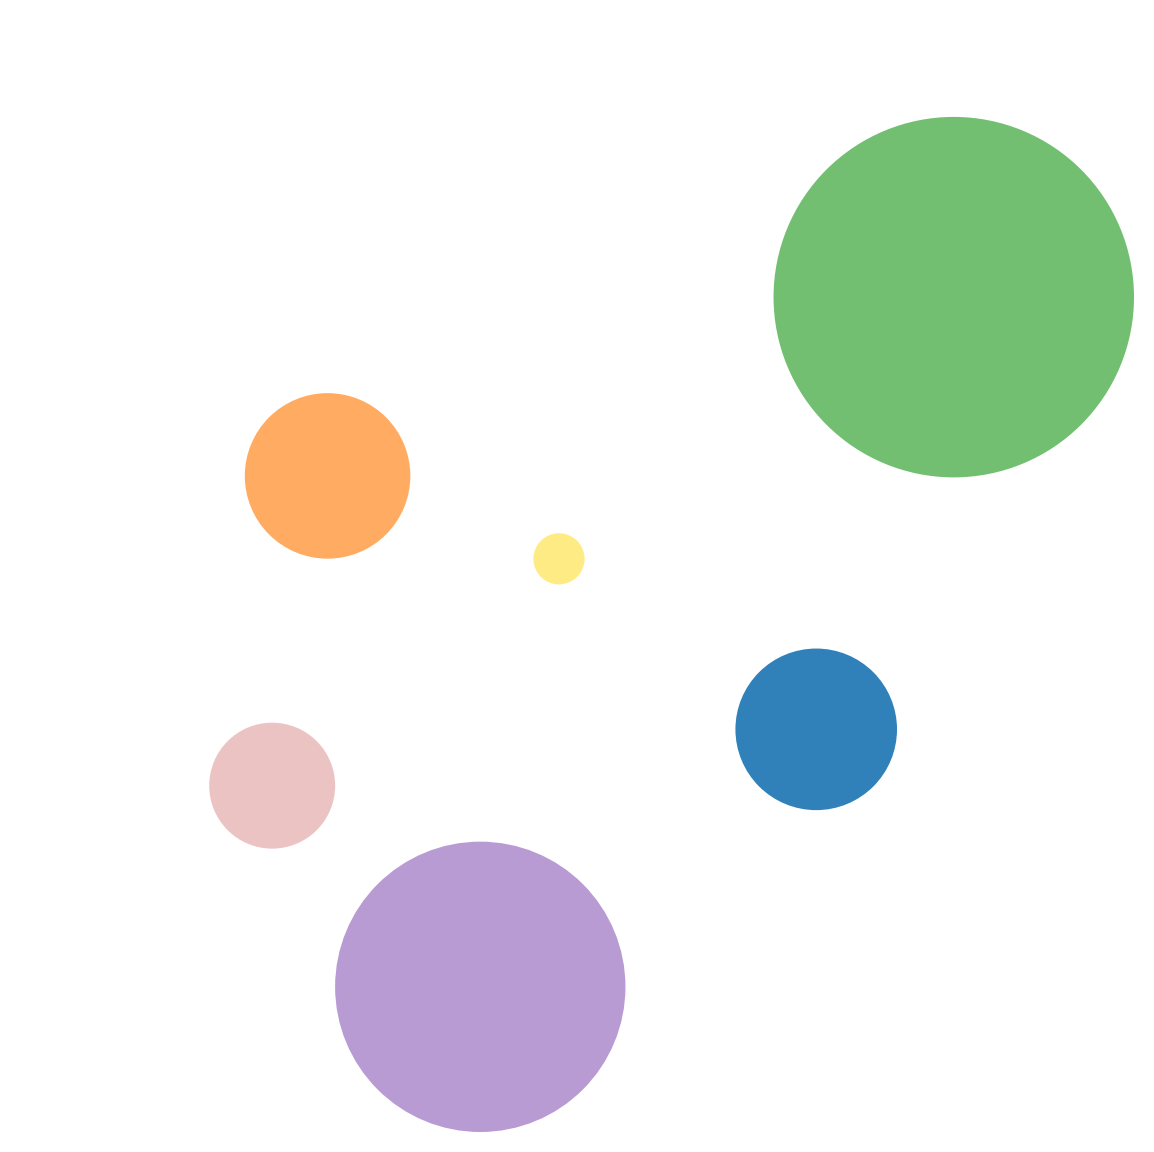

In [233]:
from evoscape.landscape_visuals import circle_plot

origin = 2
direction = (3,4)
right = None
bottom = 4
left = 0


for i in (48,):
    print(i)
    timecode = timecodes[i]

    landscape = landscape_from_timecode(CellDiff_Dataset_Landscape, timecode, data_dir, gen, landscape_pars)
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
    for j in range(5):
        fig = circle_plot(landscape, regime=j, L=5)
        plt.show()
